# A Wright-Fisher simulation implemented in C via Cython.

This tutorial implements a Wright-Fisher simulation with mutation and recombination using [Cython](http://www.cython.org).  Cython is two things:

* A grammer/dialect of Python that allows static typing Python and of C/C++ types.
* A static compiler to turn the Cython grammer in to C or C++ code to compile into a Python extension module.

Cython has a learning curve of its own. A lot of what is shown below reflects best practices.  For those, we refer you to the Cython documentation.

Here, we avoid all use of [numpy](http://www.numpy.org) until we have to talk to [msprime](http://msprime.readthedocs.io).  We replace all numpy functionality with the equivalent routines from the excellent GNU Scientific Library, or [GSL](https://www.gnu.org/software/gsl/doc/html/index.html). Yes, numpy is fast!  Numpy is written in C!  But, numpy has to talk back and forth to Python, meaning we can out-perform it by writing routines that execute completely on the C side.

This example is closer to reality for those working in lower-level languages.  First, we must build our world, which means defining data types (structs, in this case), functions acting on those types, and a bunch of auxillary code to manage memory and handle errors.  After all that, we can code up the `simplify` and `evolve` functions. Such is the price of speed.

First, we load an extension allowing us to write Cython in a notebook:

In [3]:
%load_ext Cython
# Set ourselves up for some plotting, too
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The next code block is our Cython code.  The notebook environment will magically compile it from Cython to C, from C to a compiled Python module, and load the module into memory.

The code block is unavoidably long.  It defines a single Python function called `evolve`, which may then be run later in the notebook.  All of the functions marked `cdef` are visible only as C functions by other functions within the module.  This limited function scope is why we must write everything in one giant block.

Some comments:

* We use [CythonGSL](https://github.com/twiecki/CythonGSL) to get access to GSL types and functions in Cython.  Conda or pip install it if you want to use it for your projects.
* The memory managment and error handling on the C side is minimal, and the error handling in particular is naive.
* The recombination function is 100% executed in C.  Mutation is very close to that, except for where we use the `dict` to manage the infinitely-many sites mutation model.
* We get copy-free transfer (I think...) from C to numpy arrays via Cython's typed memory views.
* The `cimport` commands below bring names into scope. It is considered best practice to only `cimport` the symbols you use, but that quickly gets tedious here, and I gave myself a break and imported everything from `gsl_vector`.

Some details:

For reasons I don't understand, attempting to pickle a `collections.namedtuple` instance in a `cdef` function raises an exception.  The workaround is a Cython class decorated with `\@cython.auto_pickle(True)`.  A side-effect is that the semantics for un-pickling the metadata differ from our Python examples.  Clearly, metadata is one of the trickier corners of `msprime/tskit`.

In [48]:
%%cython -3 -lgsl -lgslcblas -lm

import msprime
import numpy as np
import struct
cimport numpy as np
from cython.view cimport array as cvarray
from libc.stdlib cimport malloc, realloc, free
from libc.stdint cimport int32_t, uint32_t

from cython_gsl.gsl_rng cimport gsl_rng
from cython_gsl.gsl_rng cimport gsl_rng_mt19937
from cython_gsl.gsl_rng cimport gsl_rng_alloc
from cython_gsl.gsl_rng cimport gsl_rng_free
from cython_gsl.gsl_rng cimport gsl_rng_set
from cython_gsl.gsl_rng cimport gsl_rng_uniform
from cython_gsl.gsl_random cimport gsl_ran_flat
from cython_gsl.gsl_random cimport gsl_ran_poisson
from cython_gsl.gsl_vector cimport *
from cython_gsl.gsl_sort cimport gsl_sort_vector

cdef int32_t * malloc_int32_t(size_t n):
    return <int32_t*>malloc(n*sizeof(int32_t))

cdef int32_t * realloc_int32_t(void * x, size_t n):
    return <int32_t*>realloc(x,n*sizeof(int32_t))

cdef double * malloc_double(size_t n):
    return <double*>malloc(n*sizeof(double))

cdef double * realloc_double(void * x, size_t n):
    return <double*>realloc(<double *>x,n*sizeof(double))

cdef struct Mutations:
    double * pos
    int32_t * time
    int32_t * node
    size_t next_mutation, capacity
    
cdef int init_Mutations(Mutations * m):
    m.next_mutation = 0
    m.capacity = 10000
    m.pos = malloc_double(m.capacity)
    if m.pos == NULL:
        return -1
    m.time = malloc_int32_t(m.capacity)
    if m.time == NULL:
        return -1
    m.node = malloc_int32_t(m.capacity)
    if m.node == NULL:
        return -1
    return 0

cdef int realloc_Mutations(Mutations * m):
    m.capacity *= 2
    m.pos = realloc_double(m.pos,
                          m.capacity)
    if m.pos == NULL:
        return -1
    m.time = realloc_int32_t(m.time,
                            m.capacity)
    if m.time == NULL:
        return -1
    m.node = realloc_int32_t(m.node,
                            m.capacity)
    if m.node == NULL:
        return -1
    return 0

cdef void free_Mutations(Mutations * m):
    free(m.pos)
    free(m.time)
    free(m.node)
    m.next_mutation = 0
    m.capacity = 10000
    
cdef int add_mutation(const double pos,
                     const int32_t generation,
                     const int32_t node,
                     list metadata,
                     Mutations * m):
    cdef int rv = 0
    if m.next_mutation+1 >= m.capacity:
        rv = realloc_Mutations(m)
        if rv != 0:
            return rv
    m.pos[m.next_mutation] = pos
    m.time[m.next_mutation] = generation
    m.node[m.next_mutation] = node
    m.next_mutation+=1
    metadata.append(struct.pack('id',generation,pos))
    return rv
    
cdef struct Nodes:
    double * time
    size_t next_node, capacity
    
cdef int init_Nodes(Nodes * n):
    n.next_node = 0
    n.capacity = 10000
    n.time = malloc_double(n.capacity)
    if n.time == NULL:
        return -1
    return 0

cdef int realloc_Nodes(Nodes * n):
    n.capacity *= 2
    n.time = realloc_double(n.time,
                            n.capacity)
    if n.time == NULL:
        return -1
    return 0
    
cdef void free_Nodes(Nodes * n):
    if n.time != NULL:
        free(n.time)
    n.next_node = 0
    n.capacity = 10000

cdef int add_node(const double t, Nodes *n):
    cdef int rv = 0
    if n.next_node >= n.capacity:
        rv = realloc_Nodes(n)
        if rv != 0:
            return rv
    n.time[n.next_node] = t
    n.next_node+=1
    return rv
    
cdef struct Edges:
    double *left
    double *right
    int32_t *parent
    int32_t *child
    size_t next_edge, capacity
    
cdef int init_Edges(Edges * e):
    e.next_edge = 0
    e.capacity = 10000
    e.left = malloc_double(e.capacity)
    if e.left == NULL:
        return -1
    e.right = malloc_double(e.capacity)
    if e.right == NULL:
        return -1
    e.parent = malloc_int32_t(e.capacity)
    if e.parent == NULL:
        return -1
    e.child = malloc_int32_t(e.capacity)
    if e.child == NULL:
        return -1
    return 0
   
cdef int realloc_Edges(Edges * e):
    e.capacity *= 2
    e.left = realloc_double(e.left,e.capacity)
    if e.left == NULL:
        return -1
    e.right = realloc_double(e.right,e.capacity)
    if e.right == NULL:
        return -1
    e.parent = realloc_int32_t(e.parent,e.capacity)
    if e.parent == NULL:
        return -1
    e.child = realloc_int32_t(e.child,e.capacity)
    if e.child == NULL:
        return -1
    return 0

cdef void free_Edges(Edges * e):
    free(e.left)
    free(e.right)
    free(e.parent)
    free(e.child)
    e.next_edge = 0
    e.capacity = 10000
    
cdef int add_edge(const double left,const double right,
             const int32_t parent,const int32_t child,
             Edges * edges):
    cdef int rv=0
    if edges.next_edge+1 >= edges.capacity:
        rv = realloc_Edges(edges)
        if rv != 0:
            return rv
        
    edges.left[edges.next_edge] = left
    edges.right[edges.next_edge] = right
    edges.parent[edges.next_edge] = parent
    edges.child[edges.next_edge] = child
    edges.next_edge += 1
    return rv

cdef struct Tables:
    Nodes nodes
    Edges edges
    Mutations mutations
    gsl_rng * rng
    
cdef int init_Tables(Tables * t, int seed):
    cdef int rv = 0
    rv = init_Nodes(&t.nodes)
    if rv != 0:
        return rv
    rv = init_Edges(&t.edges)
    if rv != 0:
        return rv
    rv = init_Mutations(&t.mutations)
    if rv != 0:
        return rv
    t.rng = gsl_rng_alloc(gsl_rng_mt19937)
    if t.rng == NULL:
        return -1
    gsl_rng_set(t.rng, seed)
    return rv

cdef void free_Tables(Tables * t):
    free_Nodes(&t.nodes)
    free_Edges(&t.edges)
    free_Mutations(&t.mutations)
    gsl_rng_free(t.rng)
    
cdef int infsites(const double mu,
                  const int32_t generation,
                  const int32_t next_offspring_index,
                  Tables * tables,
                  list metadata,
                  dict lookup):
    cdef unsigned nmut = gsl_ran_poisson(tables.rng, mu)
    cdef unsigned i = 0
    cdef double pos
    cdef int rv = 0
    for i in range(nmut):
        pos = gsl_rng_uniform(tables.rng)
        while pos in lookup:
            pos = gsl_rng_uniform(tables.rng)
        rv = add_mutation(pos,
                         generation,
                         next_offspring_index,
                         metadata,
                         &tables.mutations)
        if rv != 0:
            return rv
        lookup[pos] = True
    return rv

cdef int value_present_vector(gsl_vector * v, double x,
                              size_t start, size_t stop):
    cdef size_t i
    for i in range(start,stop):
        if gsl_vector_get(v,i)==x:
            return 1
    return 0

cdef int poisson_recombination(const double r,
                               size_t pg1, size_t pg2,
                               const int32_t next_offspring_id,
                               Tables * tables):
    cdef unsigned nbreaks = gsl_ran_poisson(tables.rng, r)
    cdef gsl_vector * b = NULL
    cdef unsigned i = 0#,drew_zero=0
    cdef double x
    cdef int rv = 0
    cdef double left,right
    cdef int32_t p
    if nbreaks == 0:
        # The parent passes the 
        # entire region onto the child
        rv = add_edge(0.0,1.0,pg1,
                      next_offspring_id,
                      &tables.edges)
        if rv != 0:
            return rv
    else:
        b = gsl_vector_calloc(nbreaks+2) 
        while i < nbreaks:
            x = gsl_rng_uniform(tables.rng)
            while value_present_vector(b,x,0,i)==1:
                x = gsl_rng_uniform(tables.rng)
            gsl_vector_set(b,i,x)
            i += 1
        if gsl_vector_get(b,0) == 0.0:
            pg1,pg2 = pg2,pg1
            # We already have a zero
            # in there, so we need
            # to adjust size so that the 
            # 1.0 we insert below goes 
            # into the right place
            b.size -= 1
        else:
            # shift all values by 1
            # index and set element
            # 0 to 0
            # for i in range(b.size):
            #     print(gsl_vector_get(b,i))
            # print("-----")
            for i in range(b.size-1,0,-1):
                gsl_vector_set(b,i,
                              gsl_vector_get(b,i-1))
            gsl_vector_set(b,0,0.0)
                
        gsl_vector_set(b,b.size-1,1.0)
        gsl_sort_vector(b)
        # print("nbreaks=",nbreaks)
        # for i in range(b.size):
        #     print(gsl_vector_get(b,i))
        # print("//")
        # if drew_zero == 1:
        #     pg1,pg2 = pg2,pg1
        for i in range(b.size-1):
            left = gsl_vector_get(b,i)
            right = gsl_vector_get(b,i+1)
            rv = add_edge(left,right,pg1,
                          next_offspring_id,
                          &tables.edges)
            if rv != 0:
                gsl_vector_free(b)
                return rv
            pg1,pg2 = pg2,pg1
    gsl_vector_free(b)
    return 0

cdef int make_offspring(const double mu, const double r,
                        const size_t generation,
                        size_t pg1, size_t pg2,
                        const int32_t next_offspring_index,
                        list metadata,
                        dict lookup,
                        Tables * tables):
    cdef int rv
    rv = poisson_recombination(r,pg1,pg2,
                               next_offspring_index,
                               tables)
    if rv != 0:
        return -2
                
    rv = infsites(mu,generation+1,
                  next_offspring_index,
                  tables,metadata,lookup)
    if rv != 0:
        return -3
            
    rv = add_node(generation+1, &tables.nodes)
    if rv != 0:
        return -4
   
    return 0

cdef void handle_error_code(int error, Tables * tables):
    """
    Only to be called after make_offspring
    """
    if error == 0:
        return
    print("Error occurred")
    free_Tables(tables)
    if error == -2:
        raise RuntimeError("error during recombination")
    elif error == -2:
        raise RuntimeError("error during mutation")
    elif error == -4:
        raise RuntimeError("erorr adding nodes")
    else:
        raise ValueError("invalid error code")
        
cdef struct ParentalGametes:
    int32_t p1g1
    int32_t p1g2
    int32_t p2g1
    int32_t p2g2
    
cdef int pick_parents(const gsl_rng * r,
                      const int32_t N,
                      const int32_t first_parental_index,
                      ParentalGametes * pg):
    cdef int32_t p = <int32_t>gsl_ran_flat(r,0.0,<double>N)
    pg.p1g1 = first_parental_index + 2*p
    pg.p1g2 = pg.p1g1+1
    # Mendel
    if gsl_rng_uniform(r) < 0.5:
        pg.p1g1,pg.p1g2 = pg.p1g2,pg.p1g1 
    p = <int32_t>gsl_ran_flat(r,0.0,<double>N)
    pg.p2g1 = first_parental_index + 2*p
    pg.p2g2 = pg.p2g1+1
    # Mendel
    if gsl_rng_uniform(r) < 0.5:
        pg.p2g1,pg.p2g2 = pg.p2g2,pg.p2g1 

cdef int simplify(Tables * tables, 
            const double dt,
            list metadata,
            object nodes,
            object edges,
            object sites,
            object mutations):
    cdef int rv = 0,gap
    
    if tables.edges.next_edge == 0:
        return rv
    
    cdef size_t i
    cdef np.ndarray[double,ndim=1] dview,lview,rview
    cdef np.ndarray[int32_t,ndim=1] pview,cview
    # Reverse time for our new nodes
    cdef gsl_vector_view vt
    vt = gsl_vector_view_array(tables.nodes.time,<size_t>tables.nodes.next_node)
    cdef double tmax,tmin
    gsl_vector_minmax(&vt.vector,&tmin,&tmax)
    for i in range(tables.nodes.next_node):
        tables.nodes.time[i] = -1.0*(tables.nodes.time[i]-tmax)
    gsl_vector_minmax(&vt.vector,&tmin,&tmax)
    
    nodes.set_columns(time=nodes.time+dt,
                      flags=nodes.flags)
    gap=nodes.time.min()-tmax
    if gap != 1:
        return -1
    dview = np.asarray(<double[:tables.nodes.next_node]>tables.nodes.time)
    nodes.append_columns(time=dview,
                        flags=np.ones(tables.nodes.next_node,dtype=np.uint32))
    
    lview = np.asarray(<double[:tables.edges.next_edge]>tables.edges.left)
    rview = np.asarray(<double[:tables.edges.next_edge]>tables.edges.right)
    pview = np.asarray(<int32_t[:tables.edges.next_edge]>tables.edges.parent)
    cview = np.asarray(<int32_t[:tables.edges.next_edge]>tables.edges.child)
    edges.append_columns(left=lview,
                        right=rview,
                        parent=pview,
                        child=cview)
    
    # We are trying to be as fast as possible here,
    # so we'll use the more cumbersome 
    # append_columns interface instead of the 
    # much slower (but easier to understand)
    # add_rows
    cdef size_t nsites = len(sites)
    if tables.mutations.next_mutation > 0:
        encoded, offset = msprime.pack_bytes(metadata)
        # for i in range(tables.mutations.next_mutation):
        #     sites.add_row(position=tables.mutations.pos[i],
        #                  ancestral_state='0')
        #     mutations.add_row(site=nsites+i,
        #                      node=tables.mutations.node[i],
        #                      derived_state='1',
        #                      metadata=metadata[i])
        dview = np.asarray(<double[:tables.mutations.next_mutation]>tables.mutations.pos)
        sites.append_columns(position=dview,
                            ancestral_state=np.zeros(len(dview),dtype=np.int8)+ord('0'),
                            ancestral_state_offset=np.arange(len(dview)+1,dtype=np.uint32))
        pview = np.asarray(<int32_t[:tables.mutations.next_mutation]>tables.mutations.node)
        mutations.append_columns(site=np.arange(nsites,
                                                nsites+tables.mutations.next_mutation,
                                                dtype=np.int32),
                                node=pview,
                                derived_state=np.ones(len(dview),
                                                      dtype=np.int8)+ord('0'),
                                derived_state_offset=np.arange(len(dview)+1,
                                                              dtype=np.uint32),
                                metadata_offset=offset, metadata=encoded
                                )
    
    msprime.sort_tables(nodes=nodes,edges=edges,
                       sites=sites,mutations=mutations)
    samples = np.where(nodes.time == 0)[0]
    msprime.simplify_tables(samples=samples.tolist(),
                            nodes=nodes,
                            edges=edges,
                            sites=sites,
                            mutations=mutations)
    
    # "clear" our temp containers
    tables.nodes.next_node = 0
    tables.mutations.next_mutation = 0
    tables.edges.next_edge = 0
                          
    return rv

def evolve(int N, int ngens, double theta, double rho, int gc, int seed):
    nodes = msprime.NodeTable()
    edges = msprime.EdgeTable()
    sites = msprime.SiteTable()
    mutations = msprime.MutationTable()
    
    cdef double mu = theta/<double>(4*N)
    cdef double r = rho/<double>(4*N)
    cdef int rv
    cdef size_t index=0,generation=0
    cdef Tables tables
    rv = init_Tables(&tables, seed)
    if rv != 0:
        free_Tables(&tables)
        raise RuntimeError("could not initialize tables")
    
    nodes.set_columns(time=np.zeros(2*N),
                     flags=np.ones(2*N,dtype=np.uint32))
        
    cdef int32_t next_offspring_index = len(nodes)
    cdef int32_t first_parental_index = 0
    cdef dict lookup = {}
    cdef list metadata = []
    cdef size_t last_gen_gc = 0
    cdef ParentalGametes pgams
    cdef double spos
    for generation in range(<size_t>(ngens)):
        if generation>0 and generation%gc == 0.0:
            rv = simplify(&tables,
                         generation-last_gen_gc,
                         metadata,
                         nodes,edges,sites,mutations)
            if rv != 0:
                free_Tables(&tables)
                raise RuntimeError("simplification error")
            lookup = {spos:True for spos in sites.position}
            metadata.clear()
            last_gen_gc=generation
            next_offspring_index = len(nodes)
            first_parental_index = 0
        else:
            first_parental_index = next_offspring_index - 2*N
            
        for index in range(N):
            pick_parents(tables.rng,N,
                         first_parental_index,
                         &pgams)
            rv = make_offspring(mu,r,generation,
                                pgams.p1g1,pgams.p1g2,
                                next_offspring_index,
                                metadata,
                                lookup,
                                &tables)
            handle_error_code(rv,&tables)
            next_offspring_index+=1
            rv = make_offspring(mu,r,generation,
                                pgams.p2g1,pgams.p2g2,
                                next_offspring_index,
                                metadata,
                                lookup,
                                &tables)
            assert(len(lookup) >=len(sites))
            handle_error_code(rv,&tables)
            next_offspring_index+=1
            
    if tables.nodes.next_node > 0:
        rv=simplify(&tables,
                    generation+1-last_gen_gc,
                    metadata,
                    nodes,edges,sites,mutations)
        if rv == -1:
            free_Tables(&tables)
            raise RuntimeError("simplification error")
    
    free_Tables(&tables)
    return msprime.load_tables(nodes=nodes,edges=edges,
                               sites=sites,mutations=mutations)

In [49]:
%%time
ts = evolve(100, 1000, 100.0, 100.0, 1, 42)

CPU times: user 414 ms, sys: 14.5 ms, total: 428 ms
Wall time: 427 ms


Make sure that output is invariant to how often we simplify:

In [47]:
for gc in range(10,1000,29):
    ts2 = evolve(100, 1000, 100.0, 100.0, gc, 42)
    assert(ts2.tables.nodes == ts.tables.nodes)
    assert(ts2.tables.edges == ts.tables.edges)
    assert(ts2.tables.sites == ts.tables.sites)
    assert(ts2.tables.mutations == ts.tables.mutations)

AssertionError: 

In [5]:
%%time
ts = evolve(1000,10000,100.0,1000.0,1000,42)

CPU times: user 15.3 s, sys: 1.06 s, total: 16.4 s
Wall time: 16.4 s


In [6]:
%%prun -l 10 -s cumulative
ts = evolve(1000,10000,100.0,1000.0,1000,42)

         10500740 function calls in 17.501 seconds

   Ordered by: cumulative time
   List reduced from 34 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   17.501   17.501 {built-in method builtins.exec}
        1    0.006    0.006   17.501   17.501 <string>:2(<module>)
        1    7.457    7.457   17.495   17.495 {_cython_magic_735b488bb6c23573139fe102d2edf13d.evolve}
       10    0.000    0.000    4.006    0.401 tables.py:1172(sort_tables)
       10    4.006    0.401    4.006    0.401 {built-in method _msprime.sort_tables}
       10    0.000    0.000    2.593    0.259 tables.py:1232(simplify_tables)
       10    2.593    0.259    2.593    0.259 {built-in method _msprime.simplify_tables}
       10    1.946    0.195    1.980    0.198 tables.py:1282(pack_bytes)
 10000010    1.217    0.000    1.217    0.000 tables.py:641(__len__)
       10    0.000    0.000    0.145    0.015 tables.py:382(append_columns)

In [7]:
mdata = msprime.unpack_bytes(ts.tables.mutations.metadata,
                             ts.tables.mutations.metadata_offset)

In [8]:
for i in mdata:
    md = struct.unpack('id',i)

# Comparison to msprime

In this section, we compare the distribution of outputs to msprime using [pylibseq](https://github.com/molpopgen/pylibseq), a Python interface to [libsequence](http://molpopgen.github.io/libsequence/)

In [5]:
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from libsequence.polytable import SimData
from libsequence.summstats import PolySIM
from libsequence.msprime import make_SimData
import concurrent.futures
import pandas as pd
from collections import namedtuple

SummStats=namedtuple('SummStats',['S','pi','D','hprime','rmin'])

Let's take a quick tour of pylibseq:

In [6]:
# Simulate data with msprime
ts = msprime.simulate(10,mutation_rate=1,random_seed=666)

# Get it into the format expected by pylibseq
d = make_SimData(ts)

# This should look familiar! :)
print(d)

//
segsites: 10
positions: 0.26833 0.290974 0.325691 0.349762 0.369596 0.390163 0.583813 0.743047 0.767412 0.978347
0100100100
1000010000
0010001000
0100100100
0001100100
0000100101
0000100110
1000010000
1000010000
0100100100


In [7]:
# Create object to calculate summary stats
x = PolySIM(d)
# Calculate a few:
print(x.thetapi(),x.tajimasd(),x.hprime(),x.rm())

3.4666666666666672 -0.08550572842849505 0.5368222463065044 0


In [8]:
%%time
msprime_raw_data=[]
for i in msprime.simulate(10,mutation_rate=100.0/4.0,
                          recombination_rate=0.0/4., #100.0/4.0,
                          num_replicates=1000,
                          random_seed=42):
    d = make_SimData(i)
    ps = PolySIM(d)
    # A little check that the two pieces of code agree
    assert(ps.numpoly() == i.num_mutations)
    msprime_raw_data.append(SummStats(ps.numpoly(),
                                      ps.thetapi(),ps.tajimasd(),
                                      ps.hprime(),ps.rm()))

CPU times: user 5.41 s, sys: 22.3 ms, total: 5.43 s
Wall time: 5.44 s


To run the forward simulations, we will use multiple Python processes via Python 3's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) library. The short of it is that we need a Python function to send out to different processes and return results, which will be pickled into a future back in the main process.

In [21]:
def run_forward_sim(nreps,seed,repid):
    """
    Run our forward sim, calculate
    a bunch of stats, and return 
    the list.
    """
    # Not the best seeding scheme, 
    # but good enough for now...
    np.random.seed(seed)
    msp_rng = msprime.RandomGenerator(int(seed))
    seeds = np.random.randint(0,1000000,nreps) * repid
    sims = []
    for i in range(nreps):
        ts = evolve(500,40000,0.0,0.0,500,seeds[i])
        samples = np.random.choice(1000,10,replace=False)
        assert(all(ts.tables.nodes.time[samples]==0.0))
        ts2 = ts.simplify(samples=samples.tolist())
        n=msprime.NodeTable()
        e=msprime.EdgeTable()
        s=msprime.SiteTable()
        m=msprime.MutationTable()
        ts2.dump_tables(nodes=n,edges=e)
        mutgen = msprime.MutationGenerator(
            msp_rng, 100.0/(float(4*500)))
        mutgen.generate(n,e,s,m)
        ts2=msprime.load_tables(nodes=n,edges=e,sites=s,mutations=m)
        # print(samples)
        # print(n.time[samples])
        # print(s)
        # print(m)
        # Simplify from entire pop down
        # to random sample of n << 2N
        # slist = samples.tolist()
        # slist.append(8)
        # ts2=ts.simplify(slist)
        # print(ts2.num_mutations)
        # print(len(ts2.tables.nodes),
        #      len(ts2.tables.edges),
        #      len(ts2.tables.sites),
        #      len(ts2.tables.mutations))
        d=make_SimData(ts2)
        ps=PolySIM(d)
        sims.append(SummStats(ps.numpoly(),
                              ps.thetapi(),
                              ps.tajimasd(),
                              ps.hprime(),
                              ps.rm()))
    return sims

In [22]:
%%time
x=run_forward_sim(1,42,3511)
print(x)

[SummStats(S=413, pi=104.86666666666726, D=-1.4105373920620667, hprime=-0.6141738148120613, rmin=0)]
CPU times: user 17.6 s, sys: 1.21 s, total: 18.8 s
Wall time: 18.9 s


In the next bit, we map our function into four separate processes.

**Note:** We could use a `concurrent.futures.ThreadPoolExecutor` instead of the process pool executor.  However, some of our Cython functions rely on Python types (`list`, `dict`, etc.), meaning that the Global Interpreter Lock is a barrier to efficient concurrency.  In practice, we've found it better to take the hit of pickling between processes so that your simulations can run at 100% CPU in different processes.

In [30]:
%%time
fwd_sim_data=[]
np.random.seed(16463623)
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(run_forward_sim,50,np.random.randint(0,2000000,1)[0],i): i for i in range(4)}
    for fut in concurrent.futures.as_completed(futures):
        fn = fut.result()
        fwd_sim_data.extend(fn)

CPU times: user 31.4 ms, sys: 31.6 ms, total: 63 ms
Wall time: 22min 31s


In [31]:
msprime_df = pd.DataFrame(msprime_raw_data)
msprime_df['engine'] = ['msprime']*len(msprime_df.index)
fwd_df = pd.DataFrame(fwd_sim_data)
fwd_df['engine']=['forward']*len(fwd_df)
summstats_df = pd.concat([msprime_df,fwd_df])

/Users/kevin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bins
/Users/kevin/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


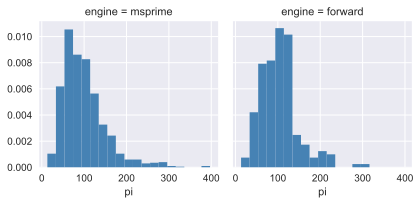

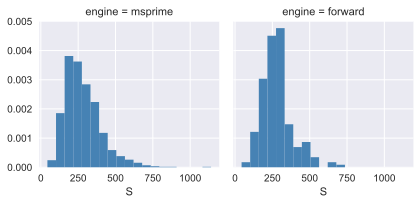

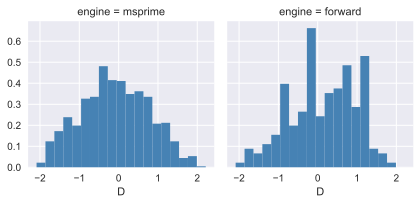

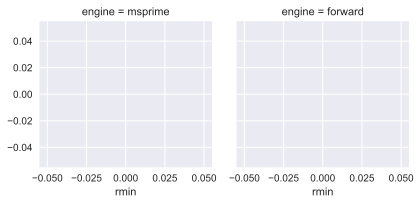

In [32]:
sns.set(style="darkgrid")
g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.pi.min(),summstats_df.pi.max(),20)
g.map(plt.hist,'pi',bins=bins,color="steelblue",lw=0,density=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.S.min(),summstats_df.S.max(),20)
g.map(plt.hist,'S',bins=bins,color="steelblue",lw=0,density=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.D.min(),summstats_df.D.max(),20)
g.map(plt.hist,'D',bins=bins,color="steelblue",lw=0,density=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.rmin.min(),summstats_df.rmin.max(),20)
g.map(plt.hist,'rmin',bins=bins,color="steelblue",lw=0,density=True);

In [33]:
len(fwd_df.index)

200

In [34]:
from scipy.stats import ks_2samp

In [35]:
print(summstats_df.groupby(['engine']).agg(['mean','std']))

               S                      pi                    D            \
            mean         std        mean        std      mean       std   
engine                                                                    
forward  283.035  100.929667  104.353111  45.144017  0.138782  0.836356   
msprime  282.824  122.831277   99.394289  50.753334 -0.091238  0.858075   

           hprime           rmin       
             mean       std mean  std  
engine                                 
forward  0.152572  0.765440    0  0.0  
msprime  0.143074  0.840379    0  0.0  


The stats are clearly off:

In [36]:
ks_2samp(fwd_df.pi,msprime_df.pi)

Ks_2sampResult(statistic=0.128, pvalue=0.0076163018453446786)

In [37]:
ks_2samp(fwd_df.S,msprime_df.S)

Ks_2sampResult(statistic=0.11899999999999999, pvalue=0.01621793025270574)

In [38]:
ks_2samp(fwd_df.D,msprime_df.D)

Ks_2sampResult(statistic=0.14400000000000002, pvalue=0.0017342886189162983)

In [39]:
ks_2samp(fwd_df.rmin,msprime_df.rmin)

Ks_2sampResult(statistic=0.0, pvalue=1.0)

## Notes:

Sat, March 3 AM: Simulating w/o recombination, w/o mutation, and w/simplification gives incorrect output.  Limits culprint to simplification OR transmission (node/edge generation).

Sun, March 4 PM: Same simulation conditions w/simplification at the end give incorrect output.  This observation would seem to clearly implicate a bug in generated nodes and/or edges. It is also possible, but seeming unlikely, that there's a bug in simplification.